In [21]:
import os
import sys
home_dir = "../../"
module_path = os.path.abspath(os.path.join(home_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

import matplotlib.pyplot as plt
%matplotlib inline 

In [25]:
task = "popu_freq"

# root_model = "tape_rao"
# model_name = "unirep" # unirep, protbert

# root_model = "sequnet_dunham"
# model_name = "sequnet"

root_model = "esm_rives"
model_name = "esm1b_t33_650M_UR50S" # esm1b_t33_650M_UR50S, esm1v_t33_650M_UR90S, esm2_t33_650M_UR50D

# root_model = "bioembeddings_dallago"
# model_name = "prottrans_t5_xl_u50" # plus_rnn, prottrans_bert_bfd, prottrans_albert_bfd, prottrans_xlnet_uniref100, prottrans_t5_bfd, prottrans_t5_uniref50, prottrans_t5_xl_u50

In [26]:
def plot_distribution(result_df):
    common = result_df[result_df["class"]=="Common"]
    rare = result_df[result_df["class"]=="Rare"]

    bins = 100 # 20, 100, 500
    plt.hist(common["pred"], bins=bins, density=False, log=False, alpha=.6, label=f"Common-{model_name}")
    plt.hist(rare["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"Rare-{model_name}")
    
    plt.legend()
    plt.show()

(95223, 14)
Index(['snp_id', 'chrom_acc_version', 'chrom_pos', 'ref_allele', 'alt_allele',
       'prot_acc_version', 'prot_pos', 'wt', 'mut', 'wt_population',
       'mut_poulation', 'wt_freq', 'mt_freq', 'pred'],
      dtype='object')
AUC-ROC: 0.565
AUC-PR: 0.562


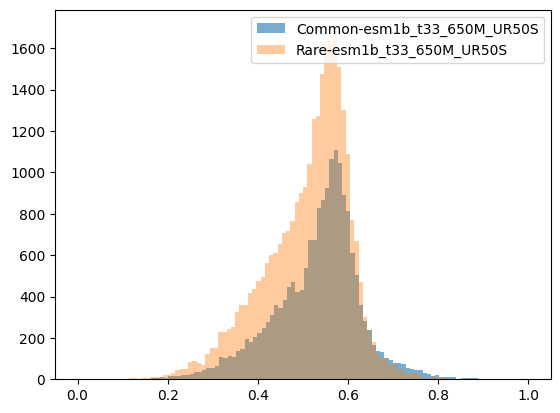

In [28]:
result_df = pd.read_csv(home_dir+f"models/{root_model}/outputs/{model_name}/{task}/preds_{model_name}_(mt-wt).csv", sep="\t")
print(result_df.shape)
print(result_df.columns)

a_col_name = "pred"
result_df = result_df[result_df["mt_freq"]>=.001] # common and rare only
result_df["pred"]=(result_df[a_col_name]-result_df[a_col_name].min())/(result_df[a_col_name].max()-result_df[a_col_name].min()) # scaling prediction scores between [0, 1]

result_df.loc[result_df["mt_freq"]>=.01, "class"] = "Common"
result_df.loc[(result_df["mt_freq"]<.01) & (result_df["mt_freq"]>=.001), "class"] = "Rare"

result_df.loc[result_df["class"]=="Common", "class_numeric"] = 0
result_df.loc[result_df["class"]=="Rare", "class_numeric"] = 1

# AUC-ROC
auc_roc_score = roc_auc_score(result_df["class_numeric"], result_df["pred"])
if auc_roc_score < 0.5: 
    auc_roc_score = 1 - auc_roc_score
print(f"AUC-ROC: {auc_roc_score:.3f}")

# AUC-PR
precision, recall, _ = precision_recall_curve(result_df["class_numeric"], result_df["pred"])
auc_pr_score = auc(recall, precision)

if auc_pr_score < 0.5: 
    auc_pr_score = 1 - auc_pr_score
print(f"AUC-PR: {auc_pr_score:.3f}")

plot_distribution(result_df)

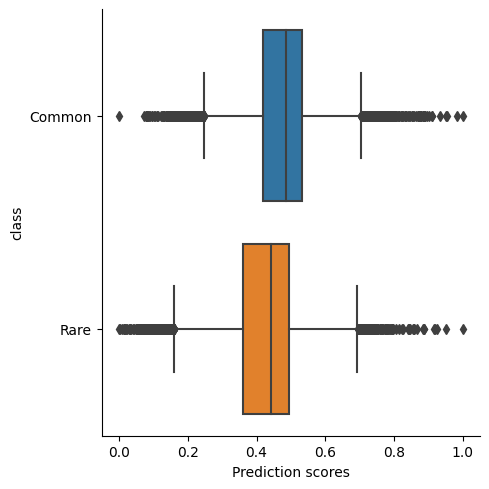

In [10]:
import seaborn as sns
fg = sns.catplot(data=common_and_rare, x="pred_normalized", y="class", order=["Common", "Rare"], kind="box")
fg.set_xlabels("Prediction scores")

/tmp/ipykernel_2801619/656006124.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common.loc[common_pred_normalized.index, "pred_normalized"] = common_pred_normalized
/tmp/ipykernel_2801619/656006124.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rare.loc[rare_pred_normalized.index, "pred_normalized"] = rare_pred_normalized


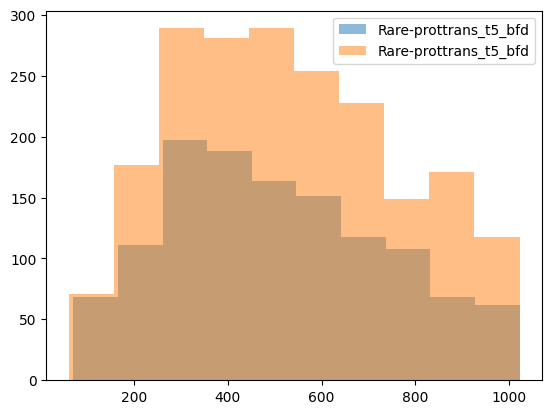

In [27]:
aa_list = common["wt"].unique()
common_pred_normalized=(common["pred"]-common["pred"].min())/(common["pred"].max()-common["pred"].min())
rare_pred_normalized=(rare["pred"]-rare["pred"].min())/(rare["pred"].max()-rare["pred"].min())

common.loc[common_pred_normalized.index, "pred_normalized"] = common_pred_normalized
rare.loc[rare_pred_normalized.index, "pred_normalized"] = rare_pred_normalized
# print(common_x)

common_x_pred = common[common["pred_normalized"] <=.3]
rare_x_pred = rare[rare["pred_normalized"] <=.3]

# common_x_pred = common[(common["pred_normalized"] >.3) & (common["pred_normalized"] <=.7)]
# rare_x_pred = rare[(rare["pred_normalized"] >.3) & (rare["pred_normalized"] <=.7)]

# common_x_pred = common[common["pred_normalized"] > .7]
# rare_x_pred = rare[rare["pred_normalized"] > .7]


####------------- correlation with seq lengths
# from Bio import SeqIO
# def get_seq_lengths(common_x_pred):
#     seq_lengths = []
#     for prot_acc_version in common_x_pred["prot_acc_version"].unique():
#         filepath = home_dir+f"data/proteins/fastas/{prot_acc_version}.fasta"
#         seq_len = len(str(SeqIO.parse(filepath, format="fasta").__next__().seq))
#         seq_lengths.append(seq_len)
#     return seq_lengths

# common_seq_lengths = get_seq_lengths(common_x_pred)
# rare_seq_lengths = get_seq_lengths(rare_x_pred)
# plt.hist(common_seq_lengths, density=False, log=False, alpha=.5, label=f"Rare-{model_name}")
# plt.hist(rare_seq_lengths, density=False, log=False, alpha=.5, label=f"Rare-{model_name}")
# plt.legend()
# plt.show()


####------------- correlation with variant position
# print(rare_x_pred["prot_pos"].value_counts(), common_x_pred["prot_pos"].value_counts(), sep="\n")
# plt.hist(common_x_pred["prot_pos"], density=False, log=False, alpha=.5, label=f"Common-{model_name}")
# plt.hist(rare_x_pred["prot_pos"], density=False, log=False, alpha=.5, label=f"Rare-{model_name}")
# plt.legend()
# plt.show()


####------------- correlation with variant amino acid
# def get_extended_dist(common_aa_dict):
#     aa_new_dict = {}
#     for aa in aa_list:
#         if aa in common_aa_dict.keys():
#             aa_new_dict[aa] = common_aa_dict[aa]
#         else: aa_new_dict[aa] = 0
#     return aa_new_dict

# common_aa_new_dict = get_extended_dist(common_x_pred["mut"].value_counts().to_dict())
# rare_aa_new_dict = get_extended_dist(rare_x_pred["mut"].value_counts().to_dict())

# a, b = zip(*sorted(common_aa_new_dict.items()))
# c, d = zip(*sorted(rare_aa_new_dict.items())) # unpack a list of pairs into two tuples
# plt.bar(a, b, alpha=.5, label=f"Common-{model_name})")
# plt.bar(c, d, alpha=.5, label=f"Rare-{model_name})")
# plt.legend()
# plt.show()